In [56]:
import numpy as np
import xarray as xr

In [57]:
mineralFilePath = 'EMIT_L2B_MIN_001_20220811T001233_2222216_001.nc'
reflectanceFilePath = 'EMIT_L2A_RFL_001_20220811T001233_2222216_001.nc'

In [58]:
refl = xr.open_dataset(reflectanceFilePath)

In [59]:
cropDowntrack = int(refl.dims['downtrack']/1)
cropCrosstrack = int(refl.dims['crosstrack']/1)

In [60]:
refl = refl.sel(downtrack=slice(0, cropDowntrack), crosstrack=slice(0, cropCrosstrack))

In [61]:
hsiData = refl['reflectance'].values
hsiData.shape

(1280, 1242, 285)

In [62]:
minerals = xr.open_dataset(mineralFilePath)
minerals = minerals.sel(downtrack=slice(0, cropDowntrack), crosstrack=slice(0, cropCrosstrack))

In [63]:
groundTruth = minerals.group_1_mineral_id.values
groundTruth.shape

(1280, 1242)

In [64]:
np.isnan(np.sum(hsiData))

False

In [65]:
print(hsiData.shape)
print(groundTruth.shape)

(1280, 1242, 285)
(1280, 1242)


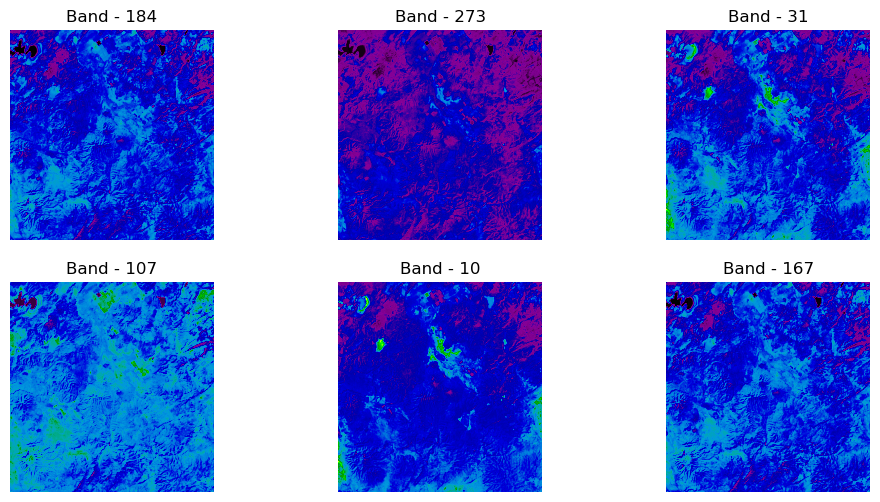

In [66]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (12, 6))

for i in range(1, 1+6):
    fig.add_subplot(2,3, i)
    q = np.random.randint(hsiData.shape[2])
    plt.imshow(hsiData[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')

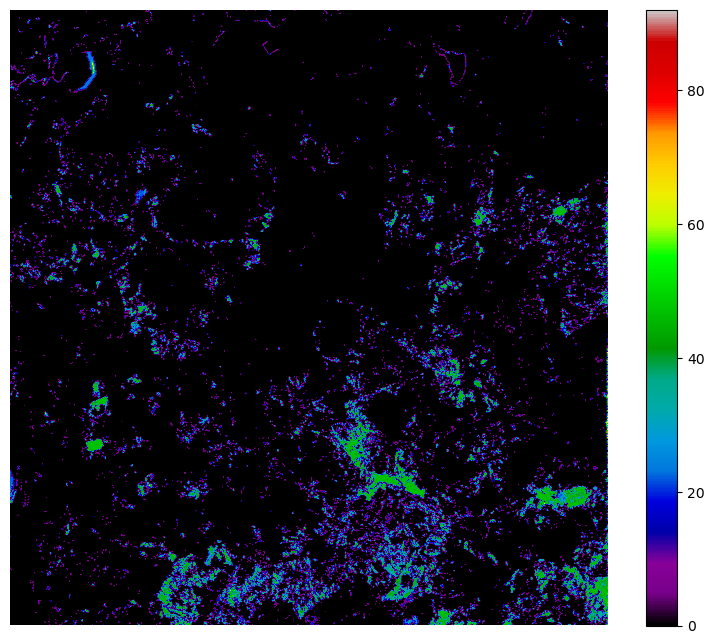

In [67]:
plt.figure(figsize=(10, 8))
plt.imshow(groundTruth, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.show()

In [68]:
X = hsiData.reshape(-1, hsiData.shape[2])
y = groundTruth.ravel()

In [69]:
import pandas as pd

X = pd.DataFrame(X)
X['gt'] = y
X.head()

,0,1,2,3,4,5,6,7,8,9,...,276,277,278,279,280,281,282,283,284,gt
0,0.010281,0.010403,0.010525,0.010649,0.010932,0.011388,0.011972,0.012628,0.013215,0.013814,...,0.021460,0.021286,0.021945,0.021045,0.020107,0.018974,0.019383,0.018503,0.017791,0.0
1,0.011180,0.011382,0.011583,0.011786,0.012148,0.012683,0.013340,0.014069,0.014724,0.015389,...,0.026586,0.025946,0.026113,0.025691,0.024153,0.024572,0.023118,0.022323,0.021669,0.0
2,0.012435,0.012749,0.013063,0.013379,0.013852,0.014502,0.015266,0.016096,0.016839,0.017584,...,0.032494,0.029946,0.029996,0.027479,0.028405,0.026994,0.026503,0.025581,0.024835,0.0
3,0.017038,0.017625,0.018211,0.018801,0.019578,0.020565,0.021674,0.022856,0.023913,0.024962,...,0.051407,0.048852,0.048247,0.044599,0.044867,0.044043,0.041095,0.039858,0.039054,0.0
4,0.017849,0.018292,0.018735,0.019183,0.019864,0.020798,0.021901,0.023103,0.024190,0.025284,...,0.051231,0.049668,0.051017,0.044889,0.045879,0.043703,0.040889,0.039307,0.039314,0.0


In [70]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1589760 entries, 0 to 1589759
Columns: 286 entries, 0 to gt
dtypes: float32(286)
memory usage: 1.7 GB


In [71]:
X.isnull().values.any()

False

In [72]:
X = X.loc[:, ~(X == -0.01).any()]
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1589760 entries, 0 to 1589759
Columns: 245 entries, 0 to gt
dtypes: float32(245)
memory usage: 1.5 GB


In [73]:
X.shape

(1589760, 245)

In [74]:
X = X.query('gt != 0')
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83370 entries, 273 to 1589759
Columns: 245 entries, 0 to gt
dtypes: float32(245)
memory usage: 78.6 MB


In [75]:
X = X[X['gt'].map(X['gt'].value_counts()) > 4]

In [76]:
y = X.pop('gt').values
y

array([47., 47., 15., ..., 47., 47., 47.], dtype=float32)

In [77]:
from collections import Counter
counter = Counter(y)
print(counter)

Counter({47.0: 66921, 32.0: 4056, 45.0: 3960, 20.0: 2508, 23.0: 946, 22.0: 861, 21.0: 824, 41.0: 655, 25.0: 425, 64.0: 302, 87.0: 193, 8.0: 174, 77.0: 130, 43.0: 121, 40.0: 116, 4.0: 107, 42.0: 100, 56.0: 88, 51.0: 80, 36.0: 79, 67.0: 75, 76.0: 68, 78.0: 68, 31.0: 66, 10.0: 56, 28.0: 51, 82.0: 48, 85.0: 44, 60.0: 31, 2.0: 23, 15.0: 22, 17.0: 21, 7.0: 18, 50.0: 13, 6.0: 13, 30.0: 13, 89.0: 12, 49.0: 9, 19.0: 9, 5.0: 8, 34.0: 6, 33.0: 6, 92.0: 6, 57.0: 5, 14.0: 5, 44.0: 5, 29.0: 5})


In [78]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [79]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components = 75)

# principalComponents = pca.fit_transform(X)

# X = principalComponents

# ev=pca.explained_variance_ratio_

# plt.figure(figsize=(12, 6))
# plt.plot(np.cumsum(ev))
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative explained variance')


# plt.show()

In [80]:
from sklearn.svm import SVC

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
print(X_train.shape)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: n {confusion_matrix(y_train, pred)}n")
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: n {confusion_matrix(y_test, pred)}n")

(41676, 244)


In [84]:
from imblearn.over_sampling import SMOTE
# transform the dataset
oversample = SMOTE(k_neighbors=2)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 3

In [226]:


# model = SVC(C=0.01, gamma=1, kernel='poly')

# pipeline = Pipeline([
#     # ('min_max_scaler', MinMaxScaler()),
#     ('std_scaler', StandardScaler()),
#     ('svm', model)
# ])

# pipeline.fit(X_train, y_train)

# print_score(pipeline, X_train, y_train, X_test, y_test, train=True)
# print_score(pipeline, X_train, y_train, X_test, y_test, train=False)

In [227]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 0.5, 1, 10, 100], 
              'gamma': [1, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001], 
              'kernel': ['rbf', 'poly', 'linear']} 

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=3, n_jobs=- 1)

grid.fit(X_train, y_train) 

best_params = grid.best_params_
print(f"Best params: {best_params}")

svm_clf = SVC(**best_params)
svm_clf.fit(X_train, y_train)

# print_score(svm_clf, X_train, y_train, X_test, y_test, train=True)
print_score(svm_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 3 folds for each of 126 candidates, totalling 378 fits


Best params: {'C': 100, 'gamma': 1, 'kernel': 'linear'}
Test Result:n================================================
Accuracy Score: 98.53%
_______________________________________________
CLASSIFICATION REPORT:n                  4.0    5.0         6.0         8.0    9.0        10.0  \
precision    0.993007    1.0    0.991736    0.979263    1.0    0.975236   
recall       1.000000    1.0    1.000000    1.000000    1.0    0.961628   
f1-score     0.996491    1.0    0.995851    0.989523    1.0    0.968384   
support    852.000000  857.0  840.000000  850.000000  842.0  860.000000   

                 15.0        20.0        21.0        22.0  ...        45.0  \
precision    0.997622    0.968750    0.976717    0.976771  ...    0.984884   
recall       1.000000    0.828107    0.983587    0.989412  ...    1.000000   
f1-score     0.998810    0.892924    0.980140    0.983051  ...    0.992384   
support    839.000000  861.000000  853.000000  850.000000  ...  847.000000   

                 47.0

In [228]:
# import joblib
# joblib.dump(svm_clf, 'svm_94acc.pkl')

In [229]:
accuracy = 0

for i in range(0, 10):
    print(i)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=i)
    svm_clf = SVC(**best_params)
    svm_clf.fit(X_train, y_train)
    pred = svm_clf.predict(X_test)
    acc = accuracy_score(y_test, pred) * 100
    print(acc)
    accuracy += acc
accuracy = accuracy / 10
print(accuracy)

0
99.83262861169838
1
99.86786469344608
2
